- Background and Data Description:
You are provided with a dataset of  images of  plant seedlings at various stages of  grown.  Each image has a filename that is its unique id. The dataset comprises 12 plant species. The goal of the projectis to create a classifier capable of determining a plant's species from a photo.nd Context
Dataset contains 2 files
- images.npy  contains images
- Labels.csv contains labels of the images.

In [1]:
# Importing Required Libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
from glob import glob
import tensorflow
import cv2
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import datasets, models, layers, optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Conv2D, Dropout, MaxPool2D,MaxPooling2D,GlobalMaxPooling2D
from keras.optimizers import RMSprop,Adam
from sklearn.metrics import classification_report, confusion_matrix





In [2]:
#loading labels dataset
seed_labels = pd.read_csv("/content/sample_data/Labels.csv")

In [3]:
seed_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [4]:
seed_labels.shape

(4750, 1)

In [5]:
# Converting the Label with an 'object' datatype into categorical variables
seed_labels["Label"] = pd.Categorical(seed_labels["Label"])
seed_labels.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Label   4750 non-null   category
dtypes: category(1)
memory usage: 5.2 KB


# There are 4750 labels and there are no missing values

In [6]:
# Checking unique values in the labels.
seed_labels['Label'].unique()

['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse', 'Common wheat', 'Common Chickweed', ..., 'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass', 'Loose Silky-bent']
Length: 12
Categories (12, object): ['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse', 'Common wheat', ...,
                          'Sugar beet', 'Maize', 'Black-grass', 'Loose Silky-bent']

# There are 12 unique labels in the data set.

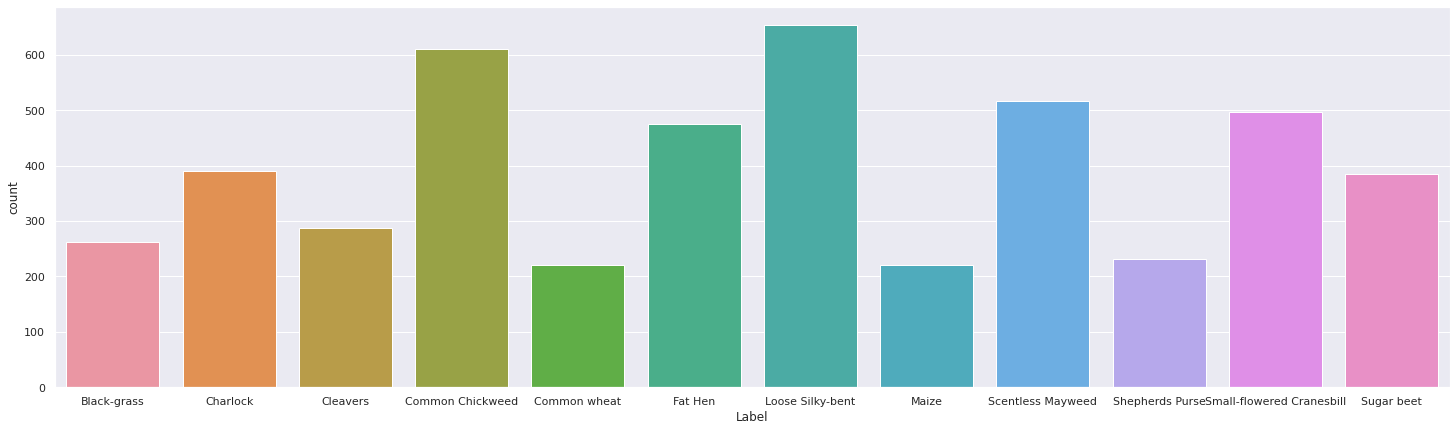

In [7]:
 sns.set(rc={'figure.figsize':(25,7)})
 ax=sns.countplot(x='Label', data=seed_labels)
   

- Looking at the lables there are 2 types of weeds in the dataset.
- Both the weeds are having good number of observations for the model to train.

In [8]:
#Loading Images Data
seed_images = np.load("/content/sample_data/images.npy")

In [9]:
# Checking Sahpe of the data
seed_images.shape

(4750, 128, 128, 3)

- Image values are already loaded into numpy Array, that is a required step for CNN, with that we can use the data values directly. 

# There are 4750 color images with 128*128 pixels.

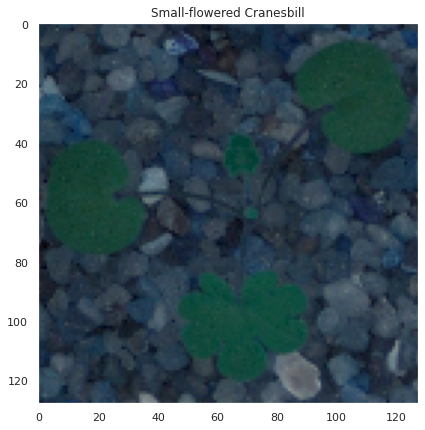

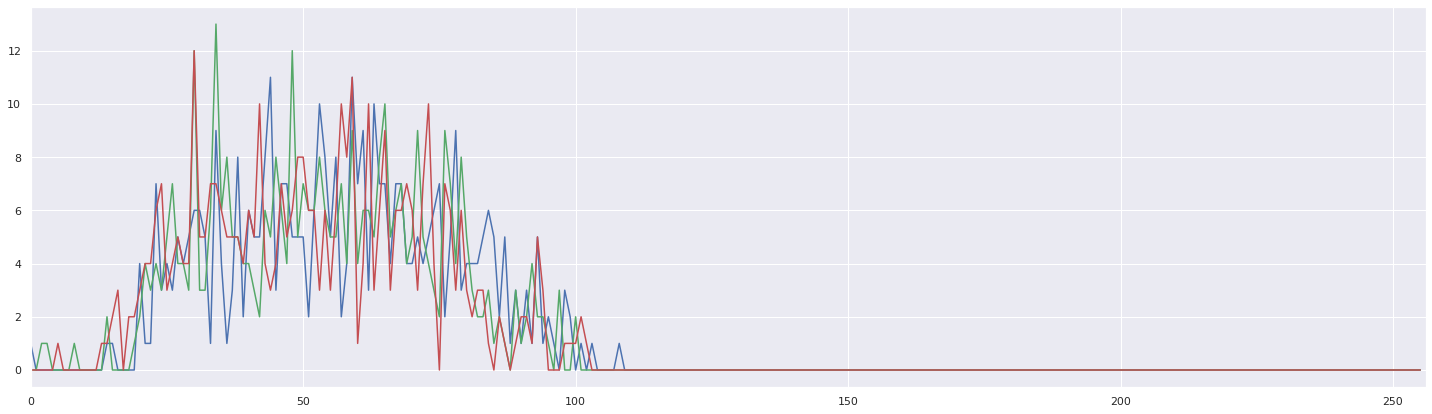

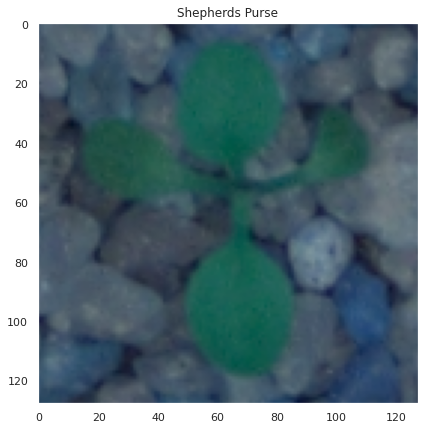

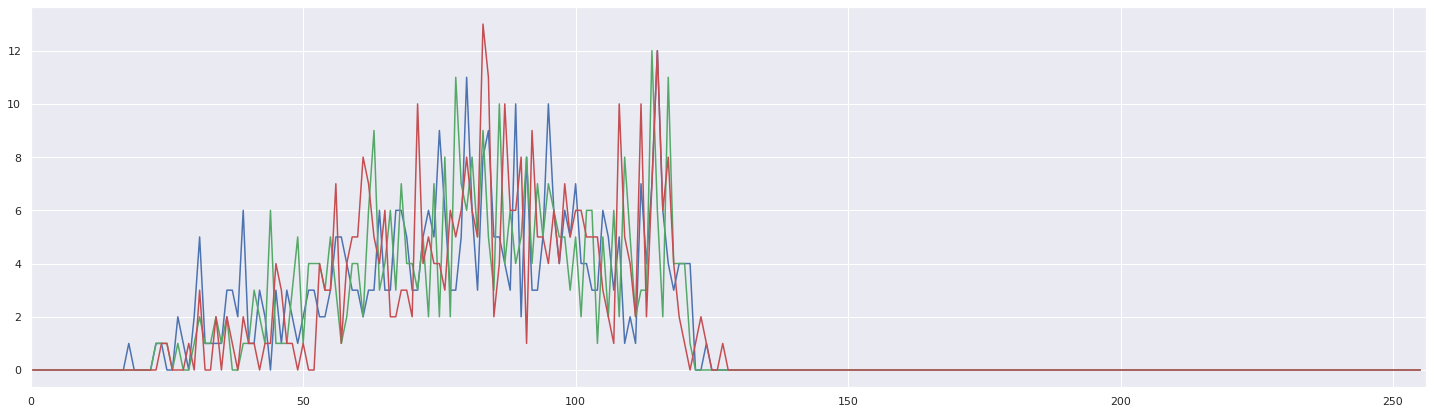

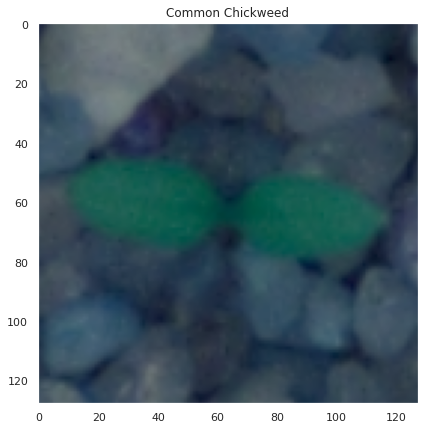

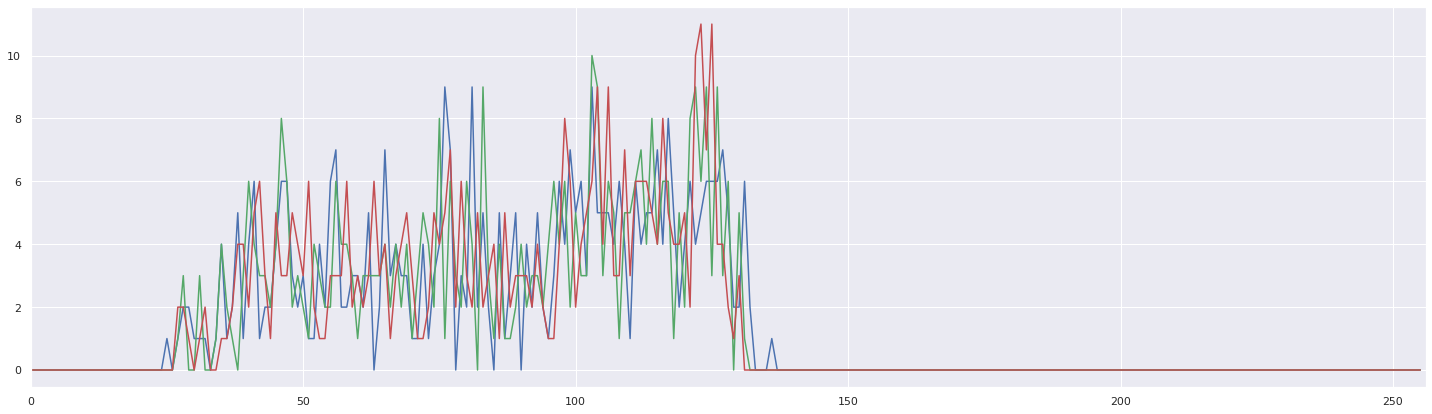

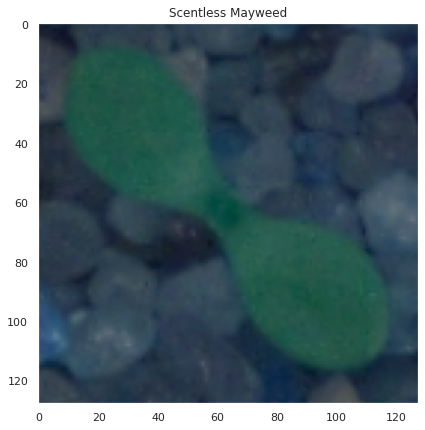

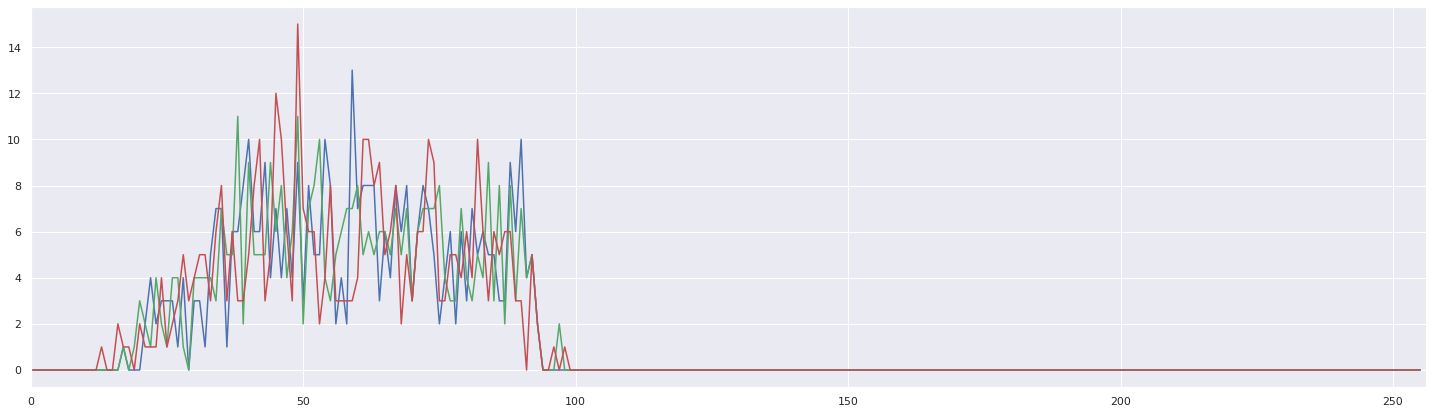

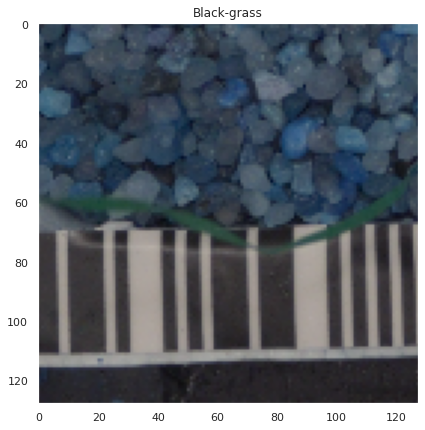

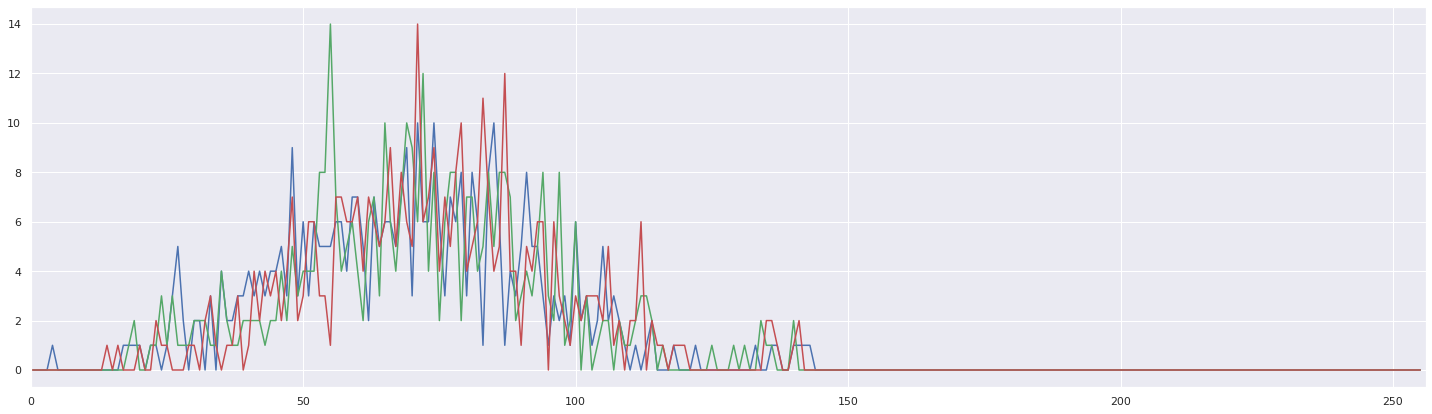

In [10]:
# Printing images randomly to check the images
for img in range(1, 4769, 1000):
  plt.grid(None) 
  plt.imshow(seed_images[img],cmap='gray')
  plt.title(seed_labels.Label[img])
  plt.show()
  color = ('b','g','r')
  plt.figure()
  for i,col in enumerate(color):
    histr = cv2.calcHist(seed_images[img],[i],None,[256],[0,256])
    plt.plot(histr,color = col)
    plt.xlim([0,256])
  plt.show()


- All the images has stones as common background.
- Some images are clear and some are not clear for the visualization.

# Data Pre-processing

- Normalizing the data by converting them into float as well as dividing with 255.


In [11]:
# Converting into float
seed_images = seed_images.astype('float32')
# Normalizing by dividing with 255
seed_images /= 255


In [12]:
print("seed_images shape:", seed_images.shape)
print("Images in seed_images:", seed_images.shape[0])
print("Max value in seed_images:", seed_images.max())
print("Min value in seed_images:", seed_images.min())

seed_images shape: (4750, 128, 128, 3)
Images in seed_images: 4750
Max value in seed_images: 1.0
Min value in seed_images: 0.0


- Gaussian blurring to reduce image noise and smoothing the data, it is a prereq to apply the model.

In [13]:
# Function to create the blur image through Gaussian by applying weights.
def blur_image(img):
    image_blurred = cv2.GaussianBlur(img, (5, 5), 3)
    weight_image = cv2.addWeighted(img, 1.5, image_blurred, -0.5, 0)
   # return weight_image
    return image_blurred
    

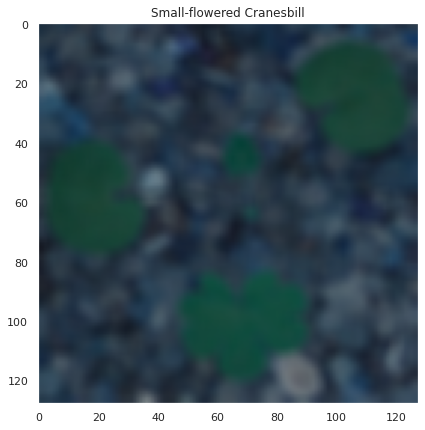

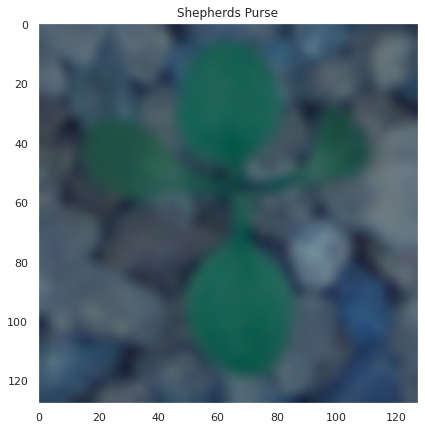

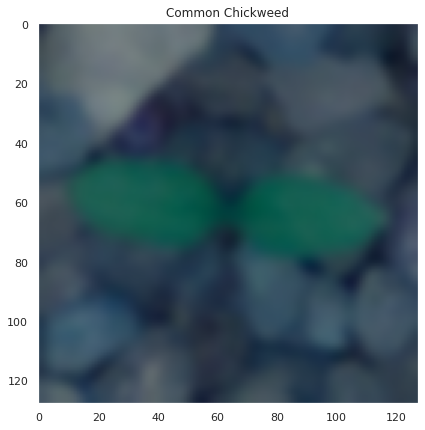

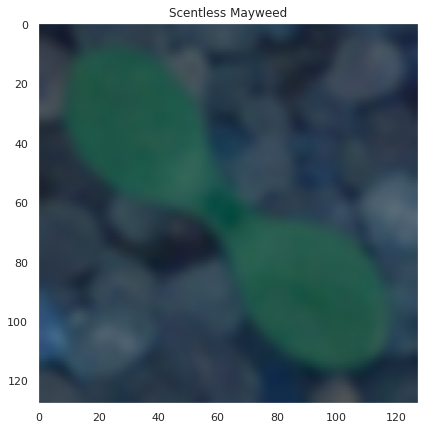

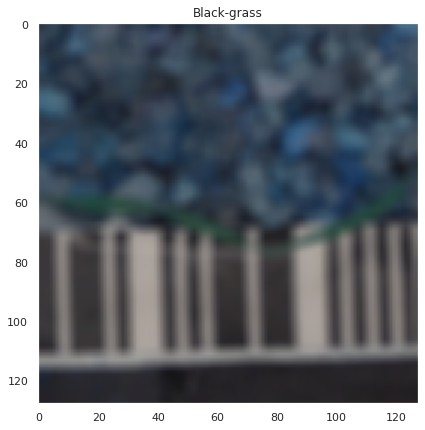

In [14]:
blur_images = np.empty((4750, 128, 128,3)) 
for indx, image in enumerate(seed_images):
  try:
     blur_images[indx] = blur_image(image)
  except Exception as ex:
    print(indx)
    print(ex)
    continue
for img in range(1, 4769, 1000):
  plt.grid(None) 
  plt.imshow(blur_images[img],cmap='gray')
  plt.title(seed_labels.Label[img])
  plt.show()
  
  

# Visualizing the images before and after data processing

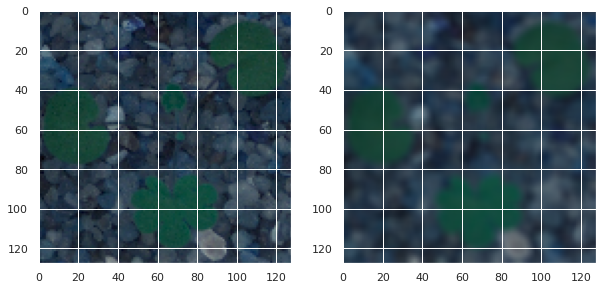

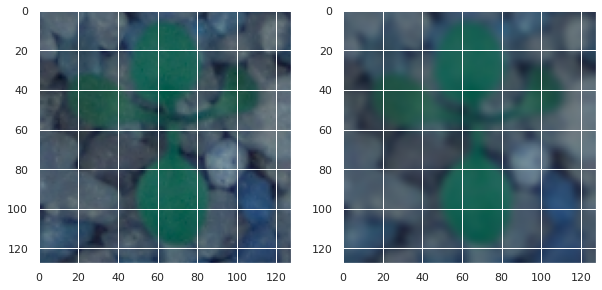

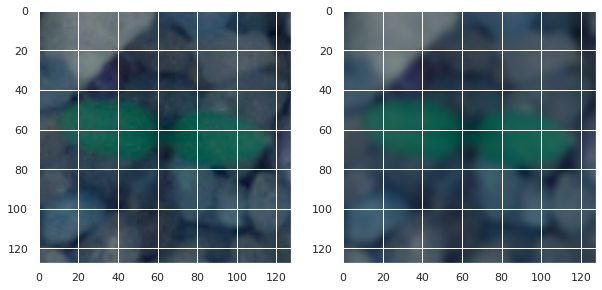

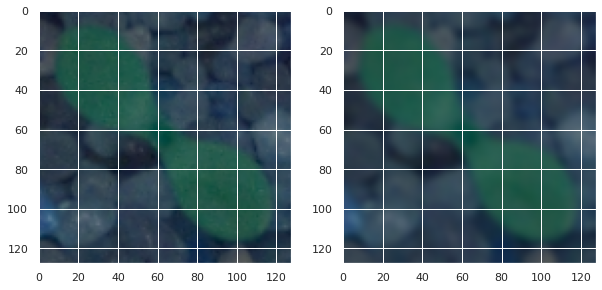

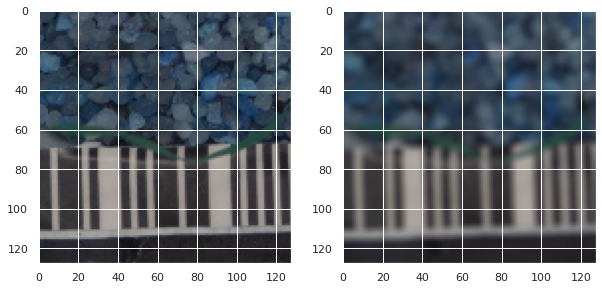

In [15]:
# Comparing the images before and after guassian blurring
# left image is original image and right image is with gaussian blurring.
for img in range(1, 4769, 1000):
  fig, axs = plt.subplots(1, 2, figsize=(10, 10))
  axs[0].imshow(seed_images[img])
  axs[1].imshow(blur_images[img])


- Images are sharpened now after the gaussian blurring.
- Noise is reduced after the blurring.
- Images are smothened after the blurring.

# Make Data Compatabile

- Convert the lables to one hot encoders by using Binarizer and later it will use the set to transform back.

In [16]:
enc = LabelBinarizer()
labels = enc.fit_transform(seed_labels)

In [17]:
labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

# Spliting data into training and testing set

In [18]:
# Spliting the data into train and test with test size 03
X_train, X_test, y_train, y_test = train_test_split(blur_images, labels, test_size=0.3, random_state=1)

In [ ]:
print("Shape of X_train.shape:", X_train.shape)
print("Shape of X_test.shape:", X_test.shape)
print("Shape of y_train.shape:", y_train.shape)
print("Shape of y_test.shape:", y_test.shape)
print("y_train[0]:",y_train[0])


Shape of X_train.shape: (3325, 128, 128, 3)
Shape of X_test.shape: (1425, 128, 128, 3)
Shape of y_train.shape: (3325, 12)
Shape of y_test.shape: (1425, 12)
y_train[0]: [0 0 0 0 0 0 0 1 0 0 0 0]


In [19]:
# Splitting the test data again test and validation with test size .5
X_test, X_val, y_test, y_val = train_test_split(X_test,y_test, test_size = 0.5, random_state=1)

In [20]:
print("Shape of X_test.shape:", X_test.shape)
print("Shape of X_val.shape:", X_val.shape)
print("Shape of y_test.shape:", y_test.shape)
print("Shape of y_val.shape:", y_val.shape)

Shape of X_test.shape: (712, 128, 128, 3)
Shape of X_val.shape: (713, 128, 128, 3)
Shape of y_test.shape: (712, 12)
Shape of y_val.shape: (713, 12)


- Checking the shape of the data

In [21]:
print("Shape of X_train.shape:", X_train.shape)
print("Shape of X_test.shape:", X_test.shape)
print("Shape of X_val.shape:", X_val.shape)

Shape of X_train.shape: (3325, 128, 128, 3)
Shape of X_test.shape: (712, 128, 128, 3)
Shape of X_val.shape: (713, 128, 128, 3)


- Sequential model in tensorflow.keras expects data to be in the format (n_e, n_h, n_w, n_c)
-n_e= number of examples, n_h = height, n_w = width, n_c = number of channels
- Shape of the X_train,X_test,X_val are compatable with the required format for Sequential model.
- with that we dont have to do the reshpae and we can continue with the same shape.

# Building CNN
- define a sequential model
- Added 2 dense layers
- Final dense layer has 12 layers to match with the number of classes in the labels.

In [22]:
# Set the CNN model 
batch_size = None
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', batch_input_shape = (batch_size,128, 128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))

model.add(GlobalMaxPooling2D())
model.add(Dense(256, activation = "relu"))
model.add(Dense(12, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 128)       7

- Set optimizer and loss function. (Use Adam optimizer and categorical crossentropy.)

In [23]:
# Optimizer as Adam and loss as categorical_crossentropy
model.compile(optimizer = Adam(lr=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [25]:
# Adding data generator to redice overfitting.
datagen = ImageDataGenerator(rotation_range=20, zoom_range = 0.1, width_shift_range=0.2, 
                             height_shift_range=0.2,horizontal_flip=True, vertical_flip=True)
datagen.fit(X_train)
batch_size = 32
epochs     = 22

In [26]:
# Fit the model with imagedatagenerator
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01)
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size), 
                        epochs=epochs, validation_data=(X_val, y_val),
                        verbose =1,callbacks=[callback])

Epoch 1/22
104/104 [==============================] - 545s 5s/step - loss: 2.4251 - accuracy: 0.1338 - val_loss: 2.2892 - val_accuracy: 0.1837
Epoch 2/22
104/104 [==============================] - 543s 5s/step - loss: 1.9979 - accuracy: 0.2965 - val_loss: 1.8750 - val_accuracy: 0.3282
Epoch 3/22
104/104 [==============================] - 543s 5s/step - loss: 1.7720 - accuracy: 0.3546 - val_loss: 1.6523 - val_accuracy: 0.3969
Epoch 4/22
104/104 [==============================] - 543s 5s/step - loss: 1.6217 - accuracy: 0.4208 - val_loss: 1.4957 - val_accuracy: 0.4670
Epoch 5/22
104/104 [==============================] - 545s 5s/step - loss: 1.4348 - accuracy: 0.4986 - val_loss: 1.3169 - val_accuracy: 0.5372
Epoch 6/22
104/104 [==============================] - 544s 5s/step - loss: 1.3059 - accuracy: 0.5477 - val_loss: 1.1763 - val_accuracy: 0.5806
Epoch 7/22
104/104 [==============================] - 546s 5s/step - loss: 1.0996 - accuracy: 0.6138 - val_loss: 1.0877 - val_accuracy: 0.6227

# Fit and evaluate modeland print confusion matrix

- Evaluating the model with the test data.

In [27]:
# Model Evaluation
score = model.evaluate(X_test, y_test, verbose=0, batch_size = 38)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.49191713333129883
Test accuracy: 0.8356741666793823


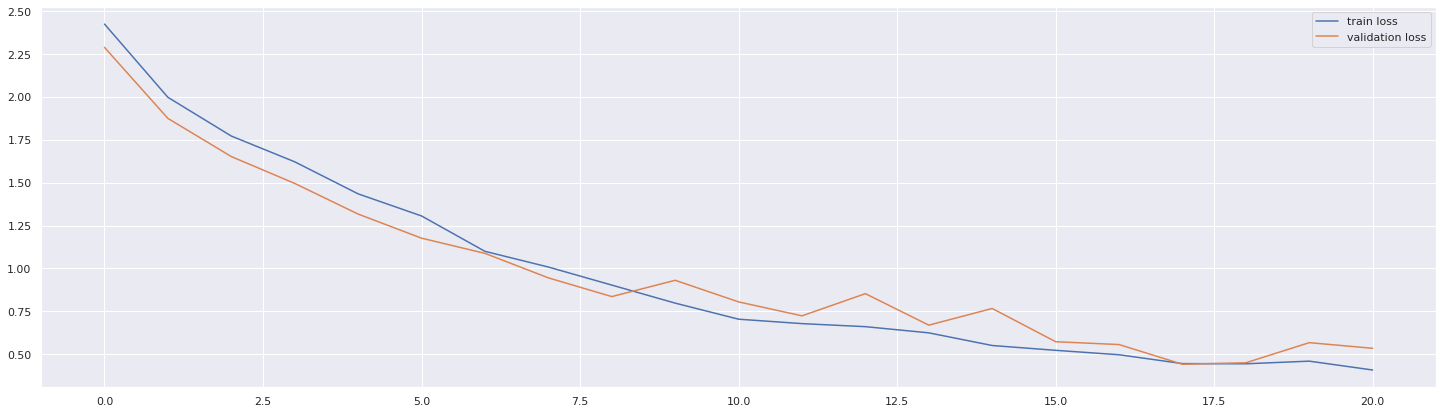

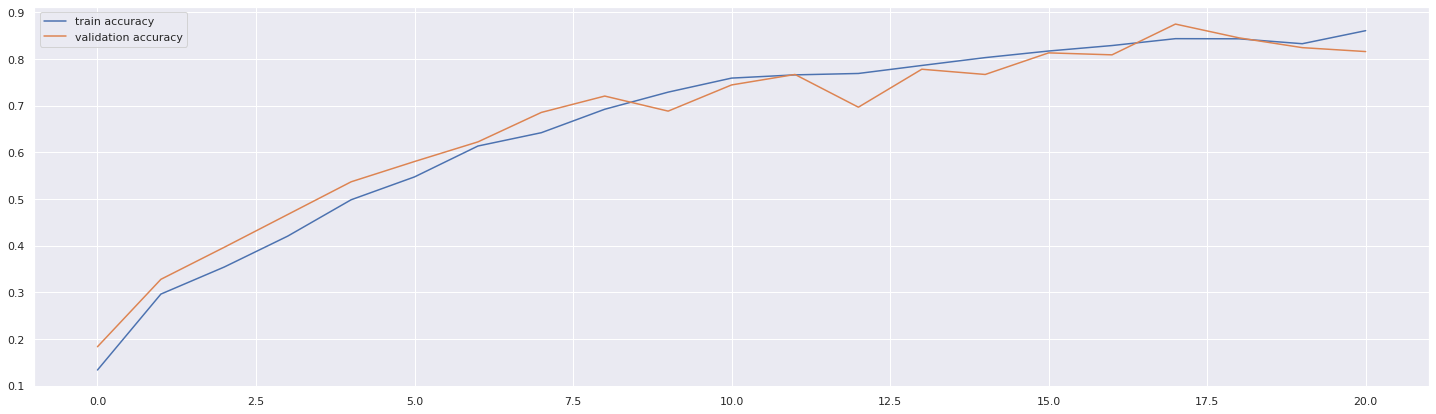

In [78]:
# plotting learning history per epoch for accuration and loss
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train loss" , "validation loss") , loc =0)
plt.show()
# Plotting accuracy at different epochs
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.legend(("train accuracy" , "validation accuracy") , loc =0)
plt.show()

# Confusion Metrics


In [79]:
# confustion metrics
y_pred = model.predict(X_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 
cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[33  0  0  0  4  0 14  0  0  0  0  0]
 [ 0 43  4  0  0  0  0  0  1  0  1  0]
 [ 0  2 40  1  1  0  0  1  2  0  0  0]
 [ 0  0  0 71  0  2  0  1  0  9  3  0]
 [ 1  0  0  0 28  0  0  0  0  0  0  0]
 [ 0  0  5  1  0 67  0  0  0  0  1  0]
 [19  0  0  0  2  0 79  0  1  0  0  0]
 [ 0  1  0  0  2  0  1 28  2  0  0  1]
 [ 0  0  4  0  1  0  0  0 60  0  2  0]
 [ 0  4  3  0  0  0  0  0  7 26  1  0]
 [ 0  2  2  0  0  0  0  0  0  1 69  0]
 [ 0  2  1  0  0  1  0  2  1  0  0 51]]


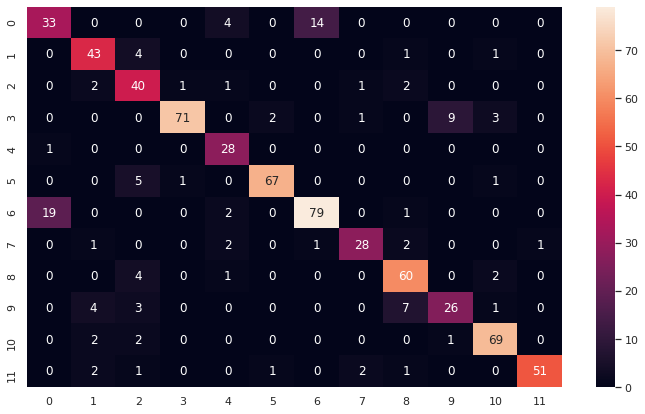

In [80]:
#Generating heatmap to understnad better about the lables
df_cm = pd.DataFrame(cmatrix, index = [i for i in range(0,12)],
                     columns = [i for i in range(0,12)])
plt.figure(figsize = (12,7))
sns.heatmap(df_cm, annot=True, fmt='d')


# Heat map findings
- Black-grass: Model predicted 33 of them correct
- Charlock:    Model predicted 43 of them correct 
- Cleavers:    Model predicted 40 of them correct
- Common Chickweed:  Model predicted 71 of them correct
- Common wheat:      28 of them are correct
- Fat Hen:           67 of them are correct
- Loose Silky-bent:   79 of them are correct
- Maize:              28 of them are correct
- Scentless Mayweed:  60  of them are correct
- Shepherds Purse:     26 of them are correct
- Small-flowered Cranesbill: 69 of them are correct
- Sugar beet:   51 of them are correct.

Model perfoormed well on all the seedlings except between Black Grass  and Loose Silky-bent 
14 of Black Grass are predicted them as Loose Silky-bent.



Visualize predictions for x_test[2], x_test[3], x_test[33], x_test[36], x_test[59]

In [46]:
Predicted_classes = model.predict_classes(X_test)


In [81]:

enc.classes_

array(['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed',
       'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
       'Scentless Mayweed', 'Shepherds Purse',
       'Small-flowered Cranesbill', 'Sugar beet'], dtype='<U25')

In [50]:
Predicted_classes

array([ 0,  4,  3,  6,  8,  8,  3,  0,  0, 11,  3,  2,  6,  1,  6,  6,  2,
        0,  1,  2,  6,  5,  6,  8,  5,  3,  6,  1,  3,  7,  8,  5,  4,  6,
       11,  9,  3,  5,  4,  7, 10,  0,  2,  1,  2,  8,  9,  0,  9,  4,  0,
        3,  7,  0, 11,  8,  0,  1,  9, 10,  8,  2,  1,  9, 10,  8,  4, 10,
        4,  1,  5, 11,  9,  8,  2, 11, 11,  8, 11,  6,  9,  5,  5,  6,  1,
       11,  2,  5,  3,  9, 10,  7,  5,  6,  9, 10,  7,  4,  7,  5,  2,  3,
        0, 11,  2,  9,  2,  6,  8,  5,  6, 10,  1,  8,  7, 11,  3, 11,  9,
        5, 10,  3,  1,  2,  6,  2,  1,  7,  5,  8, 11,  6,  6, 10,  1,  0,
        3, 10,  8,  6,  6,  1, 11,  5,  0,  8,  6, 11,  8, 11,  5,  0, 10,
        5, 11,  1,  2,  2,  3,  5, 10,  8, 11,  2,  7,  9,  0, 10, 10,  8,
        0, 10,  6,  1,  5,  2,  9,  2,  1,  9, 10,  4,  9,  6,  4,  1,  8,
        6,  9,  3,  5,  8, 11,  0, 10,  7,  5, 10, 11, 10,  1,  4, 10,  6,
        6,  6, 10,  5,  3,  1,  3, 10,  3,  8, 10, 10,  5,  9,  3, 11, 11,
        3,  6,  6,  7,  1

In [94]:
index = [2,3,33,36,59]

i value: 2
Predicted class: Common Chickweed
Actual class: Common Chickweed


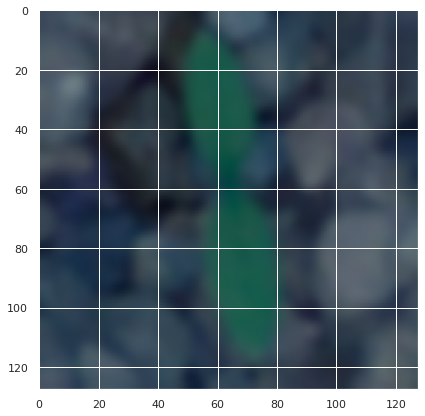

i value: 3
Predicted class: Loose Silky-bent
Actual class: Black-grass


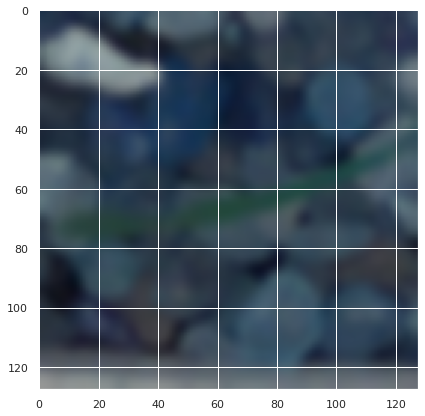

i value: 33
Predicted class: Loose Silky-bent
Actual class: Loose Silky-bent


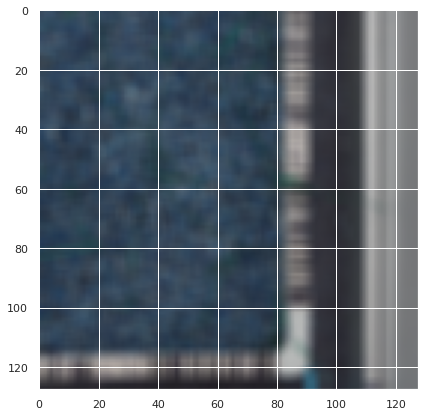

i value: 36
Predicted class: Common Chickweed
Actual class: Common Chickweed


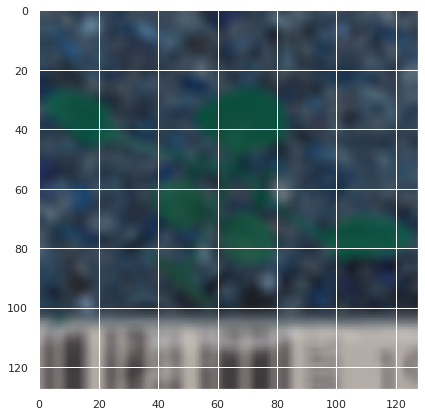

i value: 59
Predicted class: Small-flowered Cranesbill
Actual class: Small-flowered Cranesbill


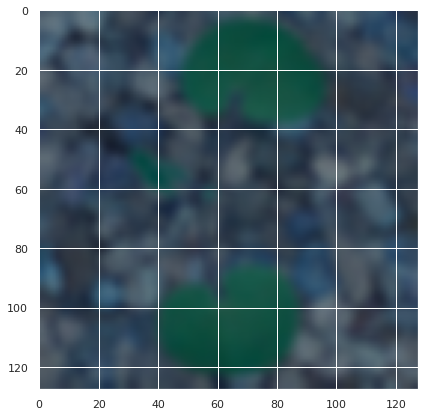

In [102]:
for i in [2,3,33,36,59]:
  act = np.argmax(y_test[i])
  print("i value:",i)
  print("Predicted class: {}".format(enc.classes_[Predicted_classes[i]]))
  print("Actual class: {}".format(enc.classes_[ np.argmax(y_test[i])]))
  plt.imshow(X_test[i])
  plt.show()